## Imports

In [1]:
import os
import numpy as np
import pandas as pd
import random
import networkx as nx
import scipy.stats as stats
from scipy.stats import chisquare,poisson,binom
from collections import Counter

#torch imports 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from torcheeg.io.eeg_signal import EEGSignalIO
from torcheeg.models import DGCNN
from torcheeg.models.gnn.dgcnn import GraphConvolution
# helper sctipts 
import utils.graph_utils as gu
import utils.data_utils as du
import utils.model_utils as mu 
import utils.visual_utils as vu
from utils.model_utils import TrainNN
from utils.cka import CKACalculator

#visualizations
import matplotlib.pyplot as plt

## Constants

In [2]:
# Path constants
path="artifacts"
data_path = "../data/"
metadata_path = data_path + "sample_metadata.tsv"
preprocessed_data_path = f"{path}/preprocessed_data.npy"
saved_path = "runs_results/models"
node_labels_path = "node_names.tsv"
node_labels = [x.split("\t")[0] for x in list(pd.read_csv(node_labels_path).iloc[:,0])]
model_obj_path = "model_runs/"

# Data preprocessing constants
bands = {"delta": [1, 4],"theta": [4, 8],"alpha": [8, 14],"beta": [14, 31],"gamma": [31, 49]}
has_val_set = False

# Model architecture
model_arch = {
    "model":DGCNN,
    "chans" : 5,
    "electrodes" : 22,
    "outputs" : 5,
    "layers" : 2,
    "hid_chans" : 16
    }

# Training parameters
train_dict = {
    "lr": 1e-4,
    "epochs": 40,
    "w_decay": 1e-3,
    }

#Models 
model_meta ={
    "amount":1,
    "plot":True,
    "plot_extensive": False,
    "new_models":True,
    "name": "dgcnn_mod"
    }

### Read data

In [3]:
## Establish connection to datafile
IO = EEGSignalIO(io_path=str(data_path), io_mode='lmdb')

## Read metadata dataframeimports
metadata = pd.read_csv(metadata_path, sep='\t')

# Verifying connection to data
idxs = np.arange(len(metadata))

# Read features and labels as torch tensors
X = torch.FloatTensor(np.array([IO.read_eeg(str(i)) for i in idxs]))
y = torch.tensor(metadata["value"].values, dtype=torch.long)

X_bde = du.band_preprocess(X, preprocessed_data_path)     

### Split data into train, validation and test sets

In [4]:
if has_val_set:
    X_train, y_train, X_val, y_val, X_test, y_test = du.split_data(X_bde, y, has_val_set=has_val_set, seed=42)
    assert (X_train.shape[0]+X_val.shape[0]+X_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    assert (y_train.shape[0]+y_val.shape[0]+y_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    
    nsamples_val, nchannels_val, bands = X_val.shape
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
    
else:
    X_train, y_train, X_test, y_test = du.split_data(X_bde, y, has_val_set=has_val_set, seed=42)
    assert (X_train.shape[0]+X_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    assert (y_train.shape[0]+y_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"

assert X_train.shape[1]==X.shape[1],"Preprossed data lost channels"
assert X_train.shape[2]==len(bands),"Preprossed data does have incorrect amount of bands"

nsamples_train, nchannels_train, bands = X_train.shape
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Train models

In [5]:
def train_models(modeltrainer,dict_model_arch, dict_training,dict_model_meta, path=path):
    """
    Training a model with random initialisation but consitent parameters. 
    
    Hyper parameters should be set outside of this function 
    
    path and model_names are both needed parameters that need to be defined outside of this function. 
    
    Path is to where your artifacts are located and model_name is what the model is called 
    
    ...
    
    Parameters
    -----------
    model : nn.modules
        The model being trained
    modeltrainer : training class
        a class for training the model provided should return a trained model
    num_models : int 
        Default 1, how many models it trains
    new : bool
        Weather it should attempt to use saved models
    """
    mods = []
    for i in range(dict_model_meta["amount"]):   
            tmp_mod = dict_model_arch["model"](in_channels=dict_model_arch["chans"], 
                                            num_electrodes=dict_model_arch["electrodes"], 
                                            hid_channels=dict_model_arch["hid_chans"], 
                                            num_layers=dict_model_arch["layers"],
                                            num_classes=dict_model_arch["outputs"])
            
            mod_name=dict_model_meta["name"]
            
            model_path=f"{path}/{mod_name}_{i}.pth"

            if dict_model_meta["amount"]>1:
                print(f"Model {i+1}")
                
            if not os.path.exists(model_path):
                    print(f"[train_models]: Could not resolve path: {model_path}")
                    dict_model_meta["new_models"]=True
                
            if dict_model_meta["new_models"] or not os.path.exists(model_path):
                
                print(f"[train_models]: Training new models")
                trainer = modeltrainer()
                
                mods.append(trainer.train_model(tmp_mod, train_loader, 
                                                    path=model_path,
                                                    name=mod_name,
                                                    has_val_set=False,
                                                    val_loader=None,
                                                    learning_rate=dict_training["lr"],
                                                    w_decay=dict_training["w_decay"],
                                                    epochs=dict_training["epochs"], 
                                                    prints=dict_model_meta["plot"],
                                                    modrun=i))   
            else:
                print(f"[train_models]: Loading models from {model_path}")
                tmp_mod.load_state_dict(torch.load(model_path))
                tmp_mod.eval()
                mods.append([tmp_mod,[]])
    return mods

In [6]:
def seed_all(seed):

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def run_models_hpc(param_list, n_runs, dict_model_arch, dict_training, dict_model_meta):

    run_idx = 1
    while run_idx < n_runs:
        random_seed = random.randint(0, 999999)
        seed_all(random_seed)
        path_name = model_obj_path + f"run_{run_idx}_seed_{random_seed}"
        print(f"[run_models_hpc] : Run idx: {run_idx}  | Curr seed: {random_seed}")
        print(f"[run_models_hpc] : Model dir: {path_name}")
        os.makedirs(path_name)
        models_dict = dict([(x, []) for x in param_list])
        
        for n_chans in param_list:
            model_name = f"model_chans_{n_chans}_seed_{random_seed}"
            
            new_dict_arch = dict_model_arch
            new_dict_arch["hid_chans"] = n_chans
            
            new_dict_meta = dict_model_meta
            new_dict_meta["name"] = model_name
            
            curr_model = [x[0] for x in train_models(TrainNN, new_dict_arch, dict_training,
                                                     new_dict_meta, path=path_name)]
            models_dict[n_chans].extend(curr_model)
        
        run_idx += 1


In [7]:
model_objs = mu.read_saved_models("model_runs/")

In [8]:
all_models = mu.get_all_models(model_objs)

train_avg, test_avg, difs_avg, train_std, test_std, difs_std = mu.avg_performance(all_models, X_train, y_train,
                                                                                  X_test, y_test, prints=True)

Average models training accuracy: 0.718
Average models test accuracy: 0.489
Average models training-test accuracy difference: 0.229
Models training accuracy SD: 0.064
Models test accuracy SD: 0.012
Models training-test accuracy difference SD: 0.060


In [9]:
def get_centers(lst):
    bary_list = []
    [bary_list.extend(x) for x in lst]
    return bary_list

def group_barycenters(lst,mapper):
    return list(map(mapper,lst))

def FCCPP_group(lst):
    return group_barycenters(lst,lambda a: 1 if a<6 else 2 if a<13 else 3 if a <18 else 4)

In [10]:
model_chans, bary_chans, sims_chans= mu.metrics_by_chans(model_objs)

graph not connected
graph not connected


In [11]:
betweeness_nodes = gu.get_max_betweeness_nodes(model_chans)
laplacian_centrality_nodes = gu.get_max_laplacian_centrality_nodes(model_chans)
current_flow_betweeness_nodes = gu.get_max_current_flow_betweeness_nodes(model_chans)

graph not connected
graph not connected


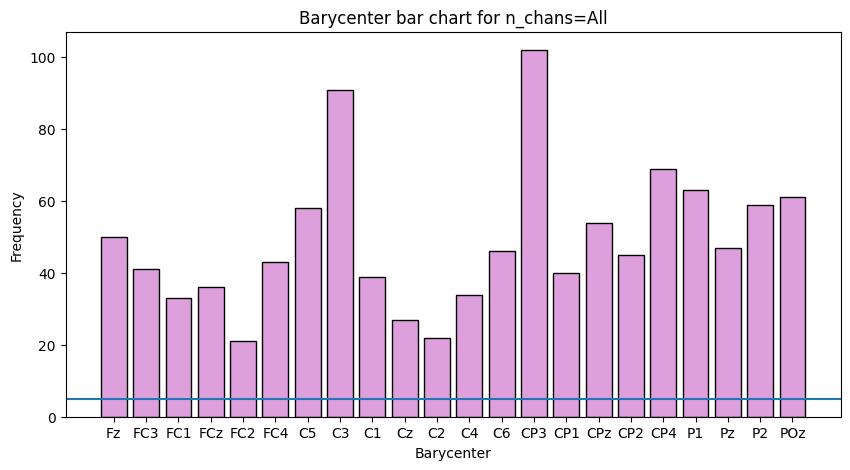

In [12]:
vu.dict_to_histogram(bary_chans, "All", node_labels, "Barycenter")
#for n_chans in bary_chans.keys():
    #vu.dict_to_histogram({n_chans: bary_chans[n_chans]}, n_chans, node_labels)

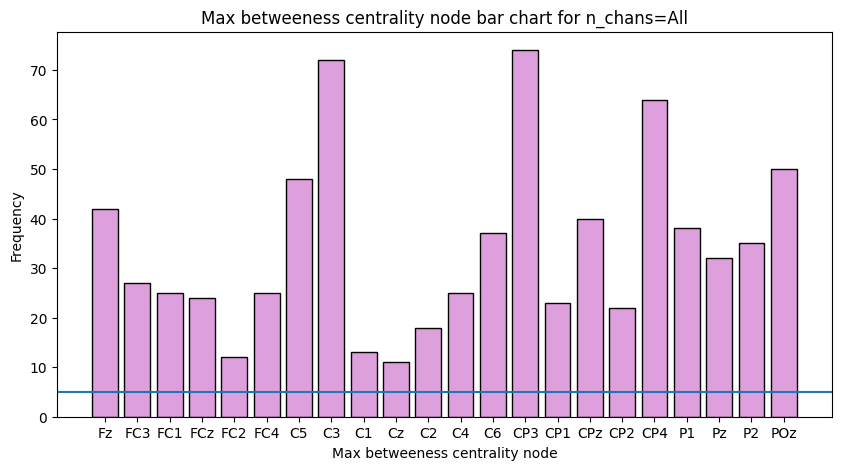

In [13]:
vu.dict_to_histogram(betweeness_nodes, "All", node_labels, "Max betweeness centrality node")

In [12]:
untrained_mods = dict()

for seed in model_objs:
    seed_all(seed)
    untrained_mods[seed] = dict()
    for n_chans in model_objs[seed]:  
        untrained_mods[seed][n_chans] = DGCNN(in_channels=model_arch["chans"], 
                        num_electrodes=model_arch["electrodes"], 
                        hid_channels=n_chans, 
                        num_layers=model_arch["layers"],
                        num_classes=model_arch["outputs"]).eval()
        
unt_model_chans, unt_bary_chans, unt_sims_chans = mu.metrics_by_chans(untrained_mods)

In [13]:
freqs_by_chan, node_counts_all, all_bary = gu.get_bary_counts(bary_chans)
_,unt_node_all,unt_bary_all=gu.get_bary_counts(unt_bary_chans)

In [49]:
def chi2(node_counts_all,comp_set,ddof=0):
    observed_counts = np.array(node_counts_all)
    if int(sum(observed_counts))==int(sum(comp_set)):
            expected_counts = np.array(comp_set) #synthetic data 

    elif sum(observed_counts)<sum(comp_set):
        expected_counts=np.array(gu.shrink(comp_set,sum(observed_counts)))
    else:
        expected_counts=np.array(gu.grow(comp_set,sum(observed_counts)))
    
    chi2_stat, p_value = chisquare(f_obs=observed_counts, f_exp=expected_counts,ddof=ddof)
    print(f"Chi-squared statistic: {chi2_stat:.3g}")
    print(f"P-value: {p_value:.3g}")

#Poisson
total = sum(node_counts_all)
# Estimate lambda as the mean of the distribution
values = np.arange(len(node_counts_all))
lambda_est = np.sum(values * node_counts_all) / sum(node_counts_all)
# Poisson expected frequencies
expected_poisson = [max(int(poisson.pmf(k, lambda_est) * total),1) for k in values]

print("\nPoisson")
chi2(node_counts_all, expected_poisson,ddof=1)
print("\nUniform")
chi2(node_counts_all,np.full(22,len(all_bary)/22))
print("\nUnaltered from training")
chi2(node_counts_all,unt_node_all)


Poisson
Chi-squared statistic: 7.62e+03
P-value: 0

Uniform
Chi-squared statistic: 172
P-value: 9.3e-26

Unaltered from training
Chi-squared statistic: 212
P-value: 1.27e-33


In [50]:
def sign_test(x, y, alternative="two-sided"):
    
    x = np.array(x); y = np.array(y)
    difs = x - y
    
    difs = difs[difs != 0]
    S = np.sum([difs > 0])
    
    p = stats.binom.cdf(k=S, n=len(difs), p=0.5)
    if alternative == "two-sided":
        p = 2 * p
    elif alternative == "bigger":
        p = 1 - p
    elif alternative != "less":
        raise Exception("Invalid value for test. Options are 'two-sided', 'less', 'bigger'")
     
    print(f"S statistic: {S}")
    print(f"P-value: {p:.3g}")
    return S, p

In [51]:
sign_test(node_counts_all, unt_node_all, alternative="less")

S statistic: 7
P-value: 0.0669


(7, 0.06690025329589844)

In [52]:
stats.wilcoxon(node_counts_all, unt_node_all)

WilcoxonResult(statistic=86.0, pvalue=0.19821882247924805)

### Print model metrics

In [53]:
if model_meta["plot_extensive"]:
    for seed in model_objs:
        for chan in model_objs[seed]:
            print(f"Model {seed}, chan: {chan} test")
            mu.model_metrics(model_objs[seed][chan], X_train, y_train, X_test, y_test, None, None,plots=model_meta["plot"])
           

### Print adjacency matrices & graphs

In [54]:
graphs=dict()
adj_mats=dict()
for seed in model_objs:
    graphs[seed]=dict()
    adj_mats[seed]=dict()
    for chan in model_objs[seed]:
        if nx.is_connected(gu.make_graph(mu.get_adj_mat(model_objs[seed][chan]))):
            adj_mats[seed][chan]=mu.get_adj_mat(model_objs[seed][chan])
            graphs[seed][chan]=gu.make_graph(adj_mats[seed][chan])
        else:
            print("graph not connected")
if model_meta["plot_extensive"]:
    for adj in adj_mats:
        vu.visualize_adj_mat(adj)
#throw error if isomophic
keys = list(graphs.keys())
for i in range(len(keys)):
    for j in range(i + 1, len(keys)):
        key1 = keys[i]
        key2 = keys[j]
        seed1 = graphs[key1]
        seed2 = graphs[key2]
        for chan1,G1 in seed1.items():
            for chan2,G2 in seed2.items():
                assert gu.check_not_isomorphism(G1,G2), f"Graph seed: {key1} chan:{chan1} and Graph seed: {key2} chan:{chan2}are isomophic"        

graph not connected
graph not connected


In [55]:
for seed in graphs:
    _bary_list=[]
    _adj_mats=[]
    for chans in graphs[seed]:
        _bary_list.append(gu.get_barycenter(adj_mats[seed][chans]))
        _adj_mats.append(adj_mats[seed][chans])
    if model_meta["plot_extensive"]:
        print(f"Graphs for seed: {seed}")
        vu.graph_plot(_adj_mats,vu.graph_visual,3,3,_bary_list)

### Plot CKA matrices

In [56]:
cka_all = []
keys = list(adj_mats.keys())
for i in range(min(len(keys),2)):
    for j in range(i + 1,min(len(keys),2)):
        key1 = keys[i]
        key2 = keys[j]
        seed1 = adj_mats[key1]
        seed2 = adj_mats[key2]
        for chan1,adj1 in seed1.items():
            for chan2,adj2 in seed2.items():
                calculator = CKACalculator(model1=model_objs[key1][chan1], 
                                model2=model_objs[key2][chan2], 
                                dataloader=train_loader,
                                layers_to_hook=(nn.Conv2d, nn.Linear,
                                nn.AdaptiveAvgPool2d, GraphConvolution, nn.BatchNorm1d))
                cka_output = calculator.calculate_cka_matrix(train_dataset)
                cka_all.append(cka_output)
                if model_meta["plot_extensive"]:
                    vu.plot_matrix(f'CKA Matrix: Model {key1}:{chan1} vs Model {key2}:{chan2}'
                          ,cka_output.cpu().numpy(),calculator.module_names_X,
                           calculator.module_names_Y)

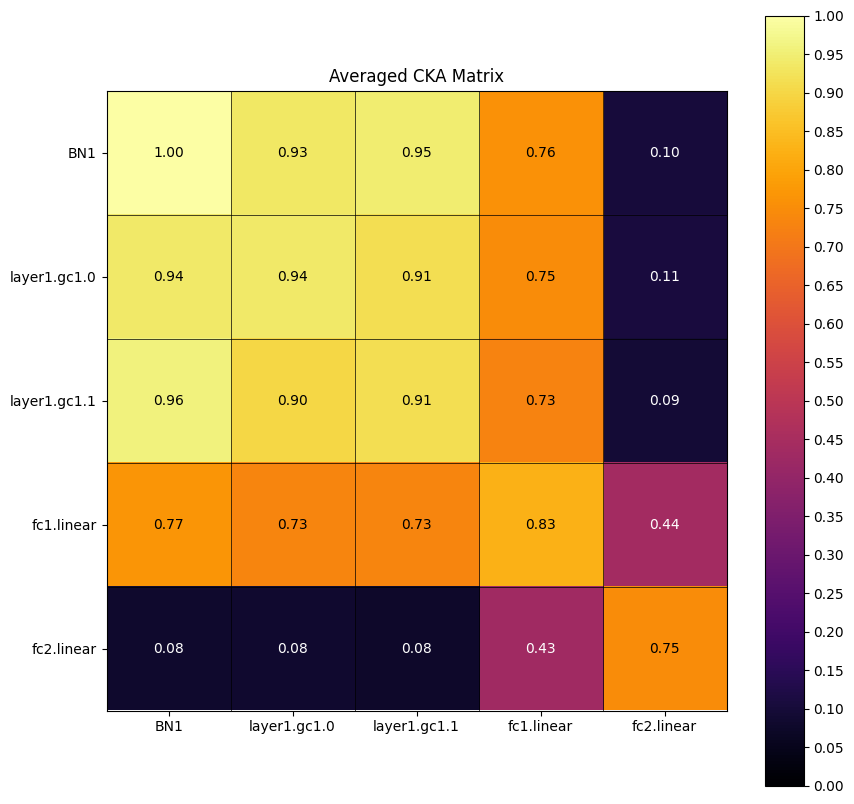

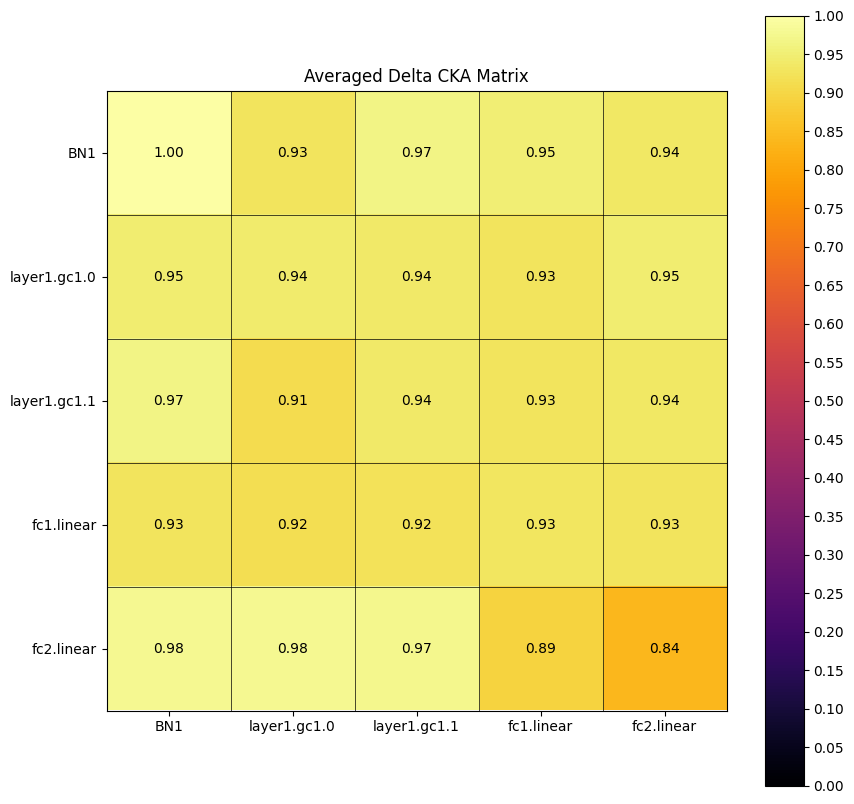

In [57]:
cka_stack = torch.stack(cka_all) 
average_cka_matrix = cka_stack.mean(dim=0)
delta_matrices = []

for i in range(len(cka_stack)):
    for j in range(i+1,len(cka_stack)):
        delta_matrices.append(torch.abs(cka_stack[i] - cka_stack[j])) 
        
delta_matrices = torch.stack(delta_matrices)  
average_delta_cka_matrix = 1- delta_matrices.mean(dim=0)  
if model_meta["plot"]:
    vu.plot_matrix("Averaged CKA Matrix",average_cka_matrix.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)
    vu.plot_matrix("Averaged Delta CKA Matrix",average_delta_cka_matrix.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)